In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install feature_engine

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Data Serialization
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from keras.models import load_model
# Traditional ML Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor


# Data manipulation and computation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Scalling
from sklearn.preprocessing import MinMaxScaler

# Encoding
from feature_engine.encoding import OneHotEncoder


# Importing Scikit-Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
def plot_day_data(day:datetime.date) -> None:
    '''
    The function "plot_day_data" plots the "Global_active_power" values 
    for a given date as input. The input date is used to filter the data
    and fill in any missing values with NaN. On the plot, the missing
    values are marked with markers. The X-axis displays xticks for the
    specified day and the Y-axis is labeled as "value". The final plot 
    is displayed using the matplotlib library.
    
    Parameters:
        day : datetime.date
        
    Return:
        None
    '''
    # Create time range and xtick for the day
    time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1T')
    xtick_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='D')
    
    # Filter the data for the day and fill missing values with NaN
    tmp_df = data[['Global_active_power']][data.index.isin(time_range)].copy()
    tmp_df = tmp_df.combine_first(pd.DataFrame(index=time_range, columns=tmp_df.columns))
    
    # Calculate the marker place
    marker_place = tmp_df[['Global_active_power']].max().item() / 2
    # Identify the missing values
    missing_values = tmp_df.isna().any(axis=1)
    
    # Drawing the plot
    plt.figure(figsize=(15, 5))
    plt.plot(
        tmp_df[['Global_active_power']][~missing_values],
        label = 'Normal Data'
    )
    plt.plot(
        tmp_df[['Global_active_power']][missing_values].fillna(marker_place), 
        marker='o', 
        linestyle='None',
        label = 'Missing Data',
        color = 'r'
    )
    plt.xticks(xtick_range, rotation=90)
    plt.grid(axis='y')
    plt.title('Global_active_power ({}:{})'.format(str(time_range[1].date()),str(time_range[-1].date())),fontsize=15)
    plt.ylabel('value')
    plt.legend()
    plt.show()
    
    return None

In [8]:
def feature_analyser(feature:str,df:pd.DataFrame) -> None:
    '''
    This function is to plot mean value of 
    given feature resampled over 'M','Q' and 'Y'

    Parameters:
        feature : string : Column name in the dataframe to be analyzed.
        df : Pandas dataframe : Dataframe to be used for analysis.

    Returns:
        None
    '''
    # Create subplots with 3 rows and 1 column, and set figure size
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,20))
    plt.subplots_adjust(hspace=0.6)  
    
    # Loop through resample intervals: monthly, quarterly, and yearly
    for number, resample in enumerate(['M', 'Q', 'Y']):
        
        df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
        ax[number].set_ylabel('{} mean'.format(feature))
        
        # Set title for each subplot
        if resample == 'M':
            ax[number].set_title('{} per month'.format(feature), fontsize=20)
        if resample == 'Q':
            ax[number].set_title('{} per quarter'.format(feature), fontsize=20)
        if resample == 'Y':
            ax[number].set_title('{} per year'.format(feature), fontsize=20)
            
        ax[number].set_xlabel('')
        ax[number].grid(axis='y')
        plt.xticks(rotation=90)
        
    plt.show()
    
    print('-----------------------------')
    
    return None

In [9]:
def LSTM_df_generator(df:pd.DataFrame(), rows_before:int=1, rows_after:int=0) -> pd.DataFrame():
    '''
    Generate a dataframe for use in LSTM models by shifting 
    the input dataframe and concatenating the shifted dataframes.
    
    Parameters:
        - df: input dataframe
        - rows_before: number of rows before the current row to shift the dataframe
        - rows_after: number of rows after the current row to shift the dataframe
    
    Returns:
        - A new dataframe with the shifted data and concatenated along the columns axis.
    '''

    # Initialize two empty lists to store the dataframes and column names
    total_df_list, columns = [], []
    
    # Loop through each row, from rows before the current row to rows after
    for row in range(-rows_before, rows_after + 1):
        # Shift the dataframe by `row` and append it to the list of dataframes
        total_df_list.append(df.shift(row))
        
        # Generate the column names based on the row index
        if row < 0:
            cols = [f'{col}(t-{-row})' for col in df.columns]
        
        elif row == 0:
            cols = [f'{col}(t)' for col in df.columns]
        
        else:
            cols = [f'{col}(t+{row})' for col in df.columns]
        
        # Add the generated column names to the list of column names
        columns.extend(cols)
    
    # Concatenate the dataframes and set the column names
    total_df = pd.concat(total_df_list, axis=1)
    total_df.columns = columns
    
    # Drop any rows with missing values
    total_df.dropna(inplace=True)
    
    # Drop notpredicting columns
    
    total_df.drop(columns=total_df.columns[-len(df.columns[1:]):],inplace=True)
    
    # Return the resulting dataframe
    return total_df

In [10]:
def create_model(
    units:int = 50, 
    dropout_rate:float = 0.2, 
    optimizer:'optimizers' = Adam, 
    learning_rate:float = 0.001, 
    batch_size:int = 100,
    epochs:int = 20
) -> 'model':
    '''
    This function creates a multi-layer RNN using LSTM with 
    two LSTM layers, a dropout layer, and a dense layer. 
    It optimizes the model using the Adam optimizer with
    a specified learning rate and compiles it using mean
    squared error loss. Arguments include number of units,
    dropout rate, optimizer, learning rate, batch size,
    and number of epochs.
    '''
    # Initialize the sequential model
    model = Sequential()
    
    # Add the first LSTM layer
    model.add(LSTM(units=units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    
    # Add the dropout layer
    model.add(Dropout(dropout_rate))
    
    # Add the second LSTM layer
    model.add(LSTM(units=units))
    
    # Add the dropout layer
    model.add(Dropout(dropout_rate))
    
    # Add the dense layer
    model.add(Dense(units=1))
    
    # Initialize the optimizer
    optimizer = optimizer(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(loss='mse', metrics=['mse'], optimizer=optimizer)
    
    # Return the compiled model
    return model

In [11]:
def get_weekday(datetime_obj:pd.Timestamp) -> str:
    '''
    Get the day of the week as a string value, given a Pandas Timestamp object.
    
    Parameters:
        - datetime_obj : A Pandas Timestamp object representing a specific date and time.
    
    Returns:
        - A string value representing the corresponding day of the week (Monday through Sunday).
    '''
    weekday = datetime_obj.weekday()
    
    if weekday == 0:
        return 'monday'
    if weekday == 1:
        return 'tuesday'
    if weekday == 2:
        return 'wednesday'
    if weekday == 3:
        return 'thursday'
    if weekday == 4:
        return 'friday'
    if weekday == 5:
        return 'saturday'
    if weekday == 6:
        return 'sunday'

In [12]:
def get_season(datetime_obj:pd.Timestamp) -> str:
    '''
    Get the season as a string value, given a Pandas Timestamp object.
    
    Parameters:
        - datetime_obj : A Pandas Timestamp object representing a specific date and time.

    
    Returns:
        - A string value representing the corresponding season (winter, spring, summer, or fall).
    '''
    month = datetime_obj.month

    if month == 12 or month <= 2:
        return 'winter'
    elif month <= 5:
        return 'spring'
    elif month <= 8:
        return 'summer'
    elif month <= 11:
        return 'fall'

In [13]:
# Read the CSV file
data = pd.read_csv(
    "D:/Household Energy consumption forcast/household_power_consumption.txt", 
    sep=';', 
    parse_dates={'dt': ['Date', 'Time']},
    infer_datetime_format=True,
    na_values=['nan', '?'],
    index_col='dt'
)

# Drop missing values
data.dropna(inplace=True)

C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\1660517490.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\1660517490.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\1660517490.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(


C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\2893382364.py:7: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  missing_days_df = np.round(data[['Global_active_power']].resample('m').count()/1440).astype(int)


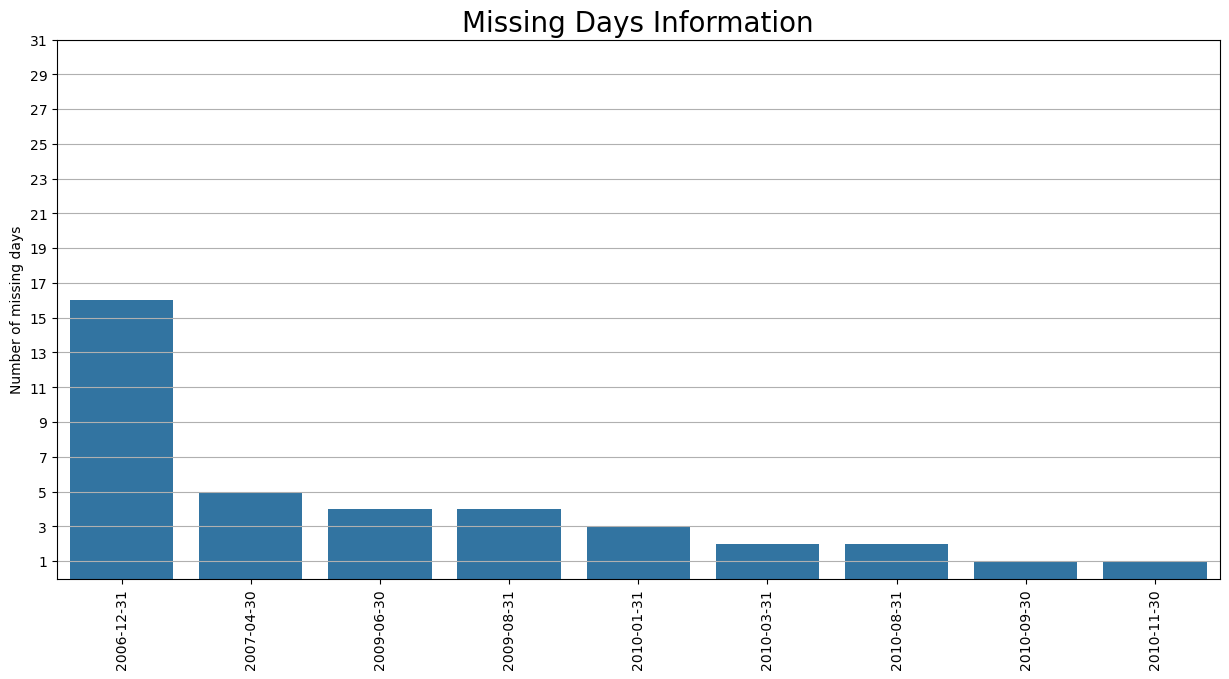

In [14]:
'''
    In the first place I would like to determine the accuracy of the data recording
    in our dataset, including any data gaps and their duration, and the
    range of days for which data was recorded.
'''
# Let's find out how many days have not been recored in our dataset
missing_days_df = np.round(data[['Global_active_power']].resample('m').count()/1440).astype(int)
missing_days_df.columns = ['Number of missing days']
missing_days_df['Number of missing days'] = missing_days_df.index.astype(str).str[-2:].astype(int) - missing_days_df['Number of missing days']
# Drop the rows where the number of missing days is 0
missing_days_df.drop(missing_days_df[missing_days_df['Number of missing days']==0].index,inplace=True)

# Drawing the plot
plt.figure(figsize=(15,7))
sns.barplot(
    data = missing_days_df,
    x = missing_days_df.index.date,
    y = missing_days_df.sort_values(by=['Number of missing days'],ascending=False)['Number of missing days']
)
plt.xticks(rotation = 90)
plt.yticks(np.arange(1,32,2))
plt.xlabel('')
plt.grid(axis='y')
plt.title('Missing Days Information',fontsize=20)
plt.show()

C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\2316342061.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1T')


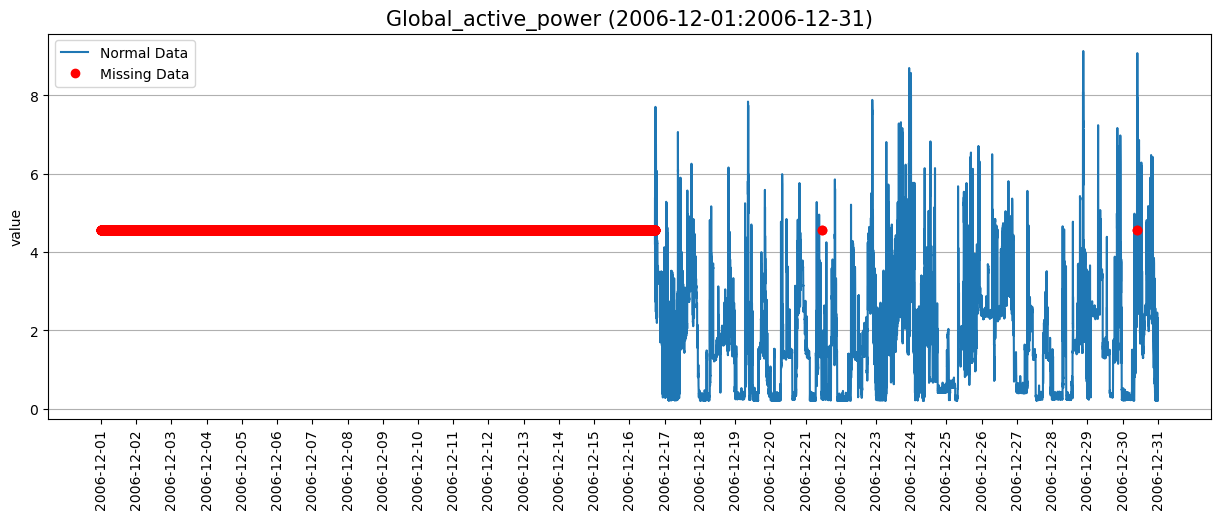

C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\2316342061.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1T')


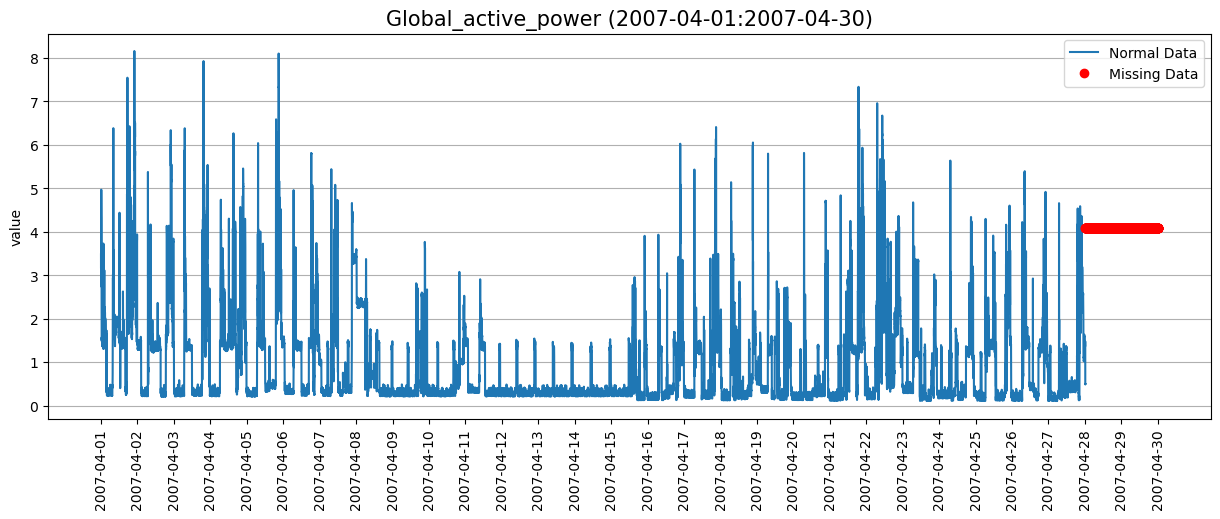

C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\2316342061.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1T')


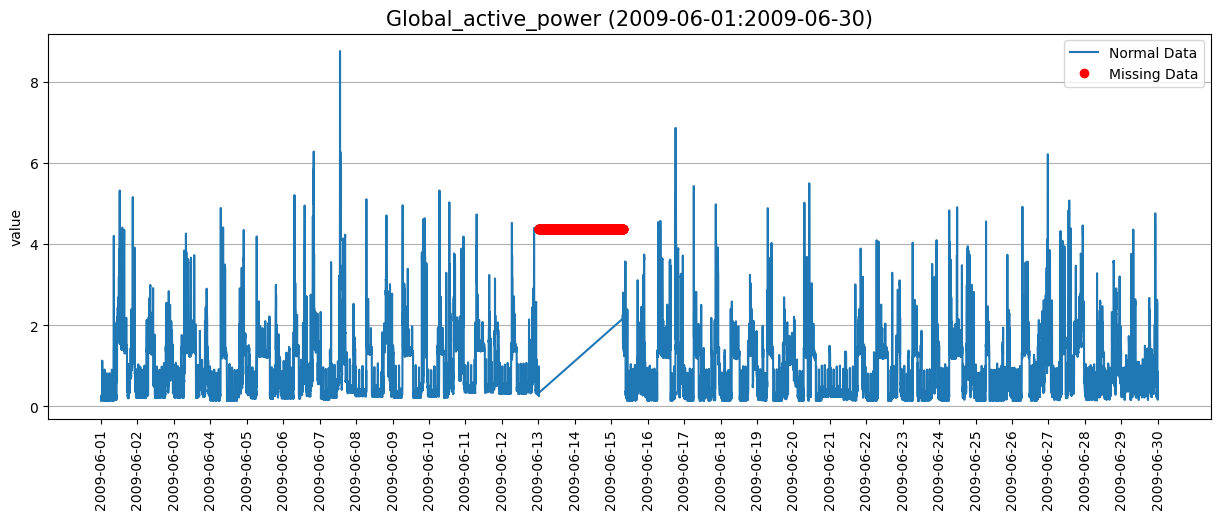

C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\2316342061.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1T')


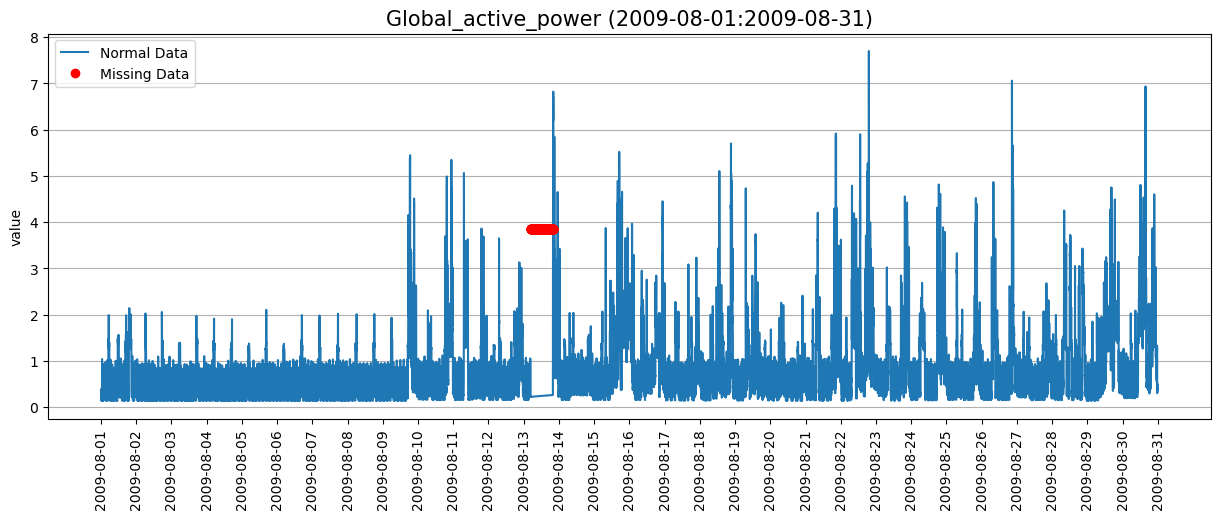

C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\2316342061.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1T')


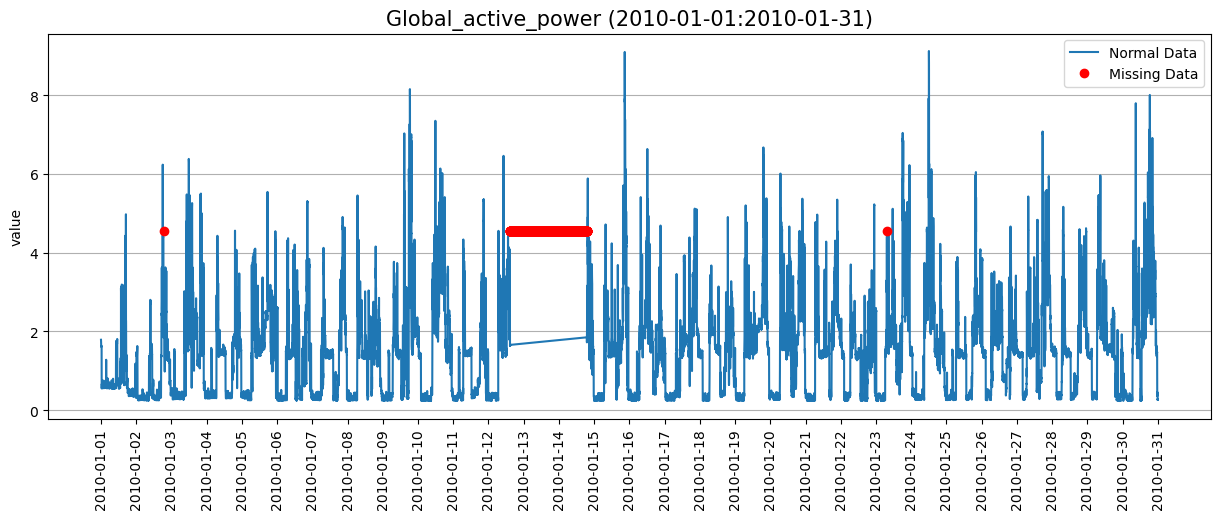

C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\2316342061.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1T')


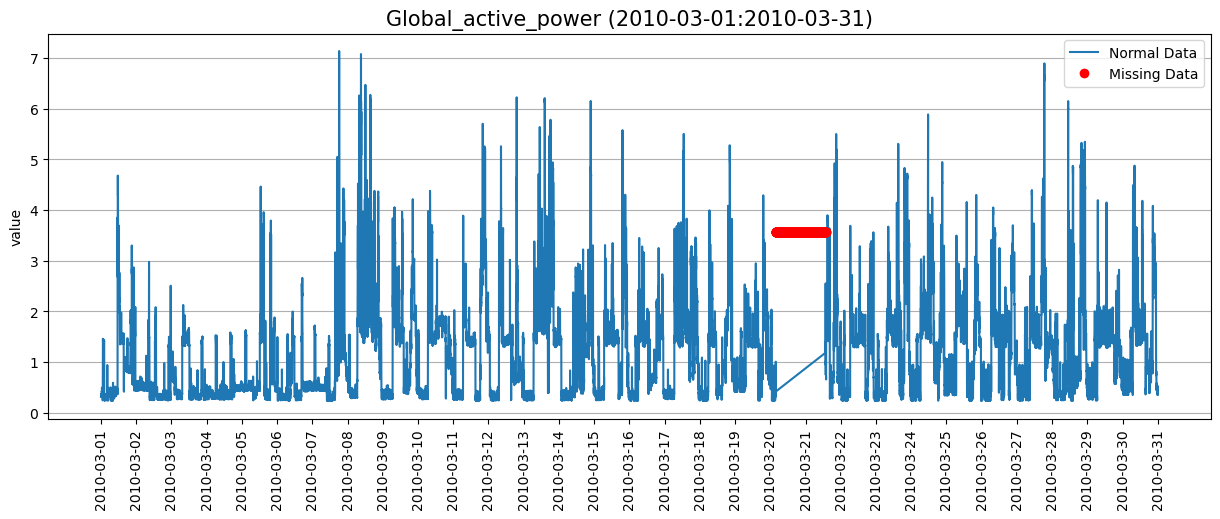

C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\2316342061.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1T')


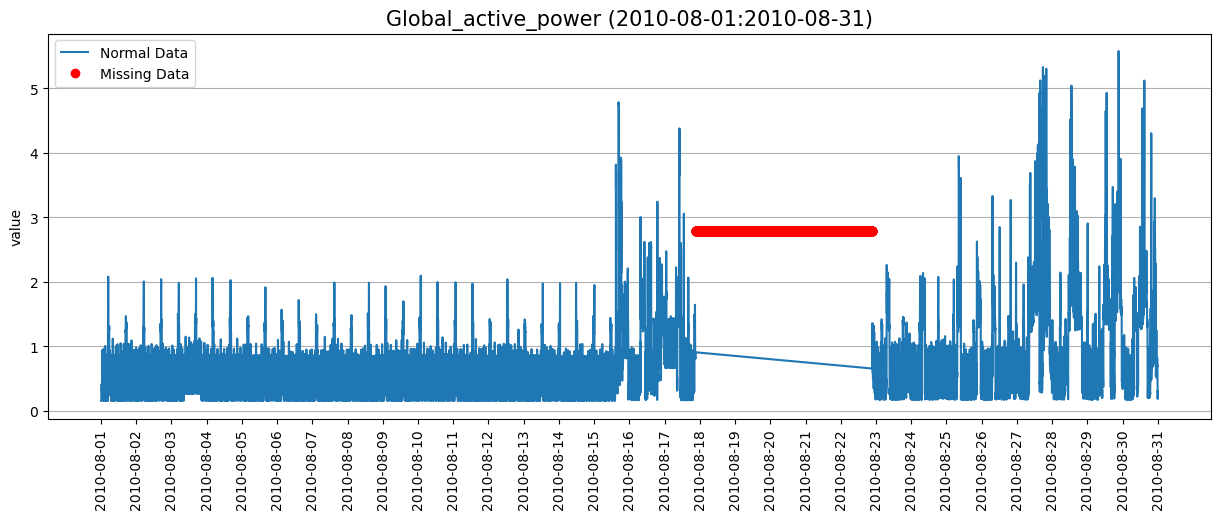

C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\2316342061.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1T')


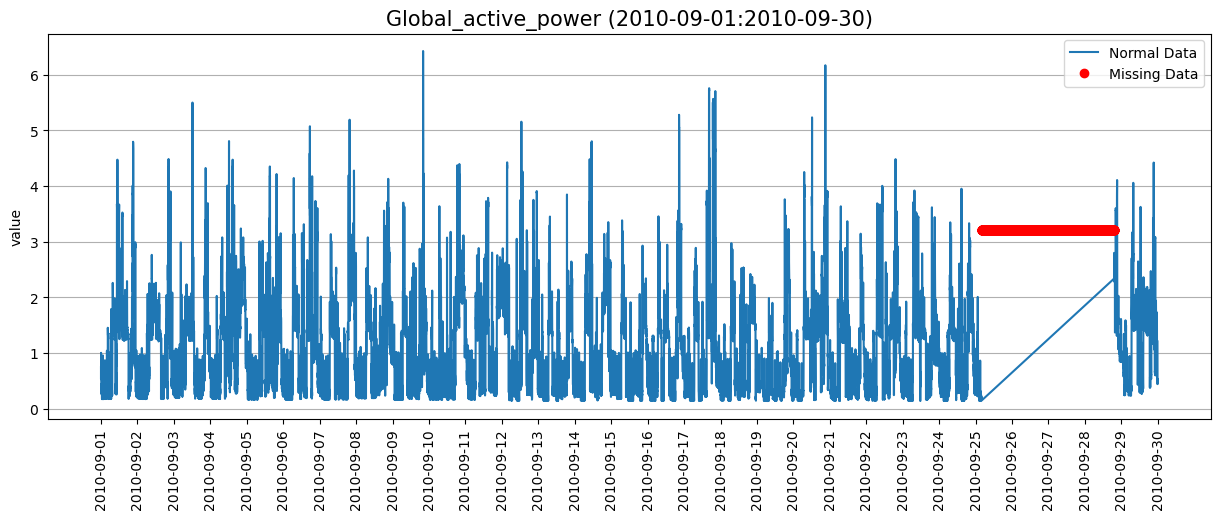

C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\2316342061.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1T')


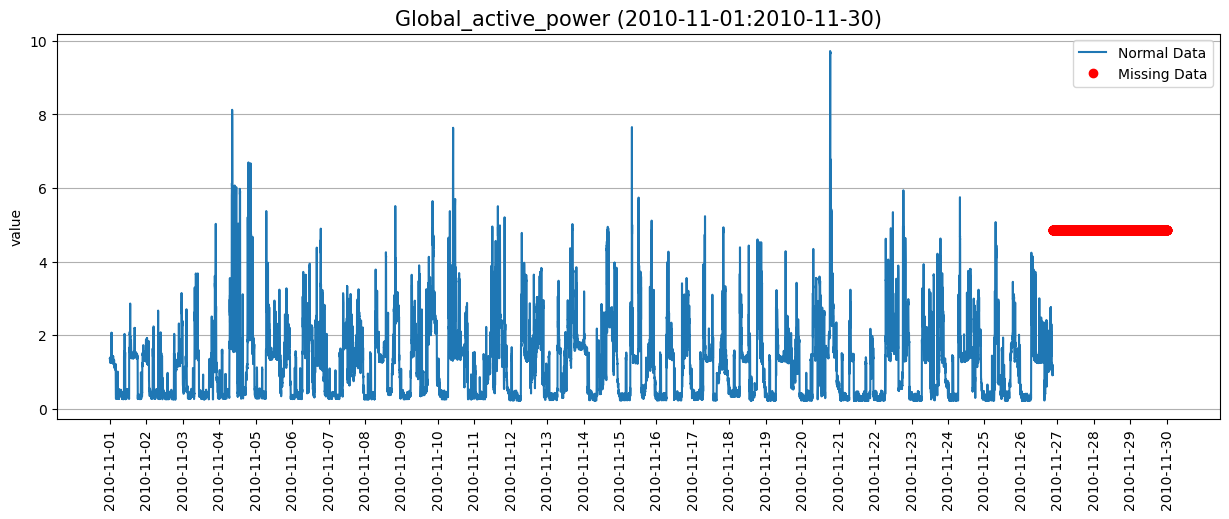

In [15]:
for day in missing_days_df.index.date:
    plot_day_data(day)

C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])


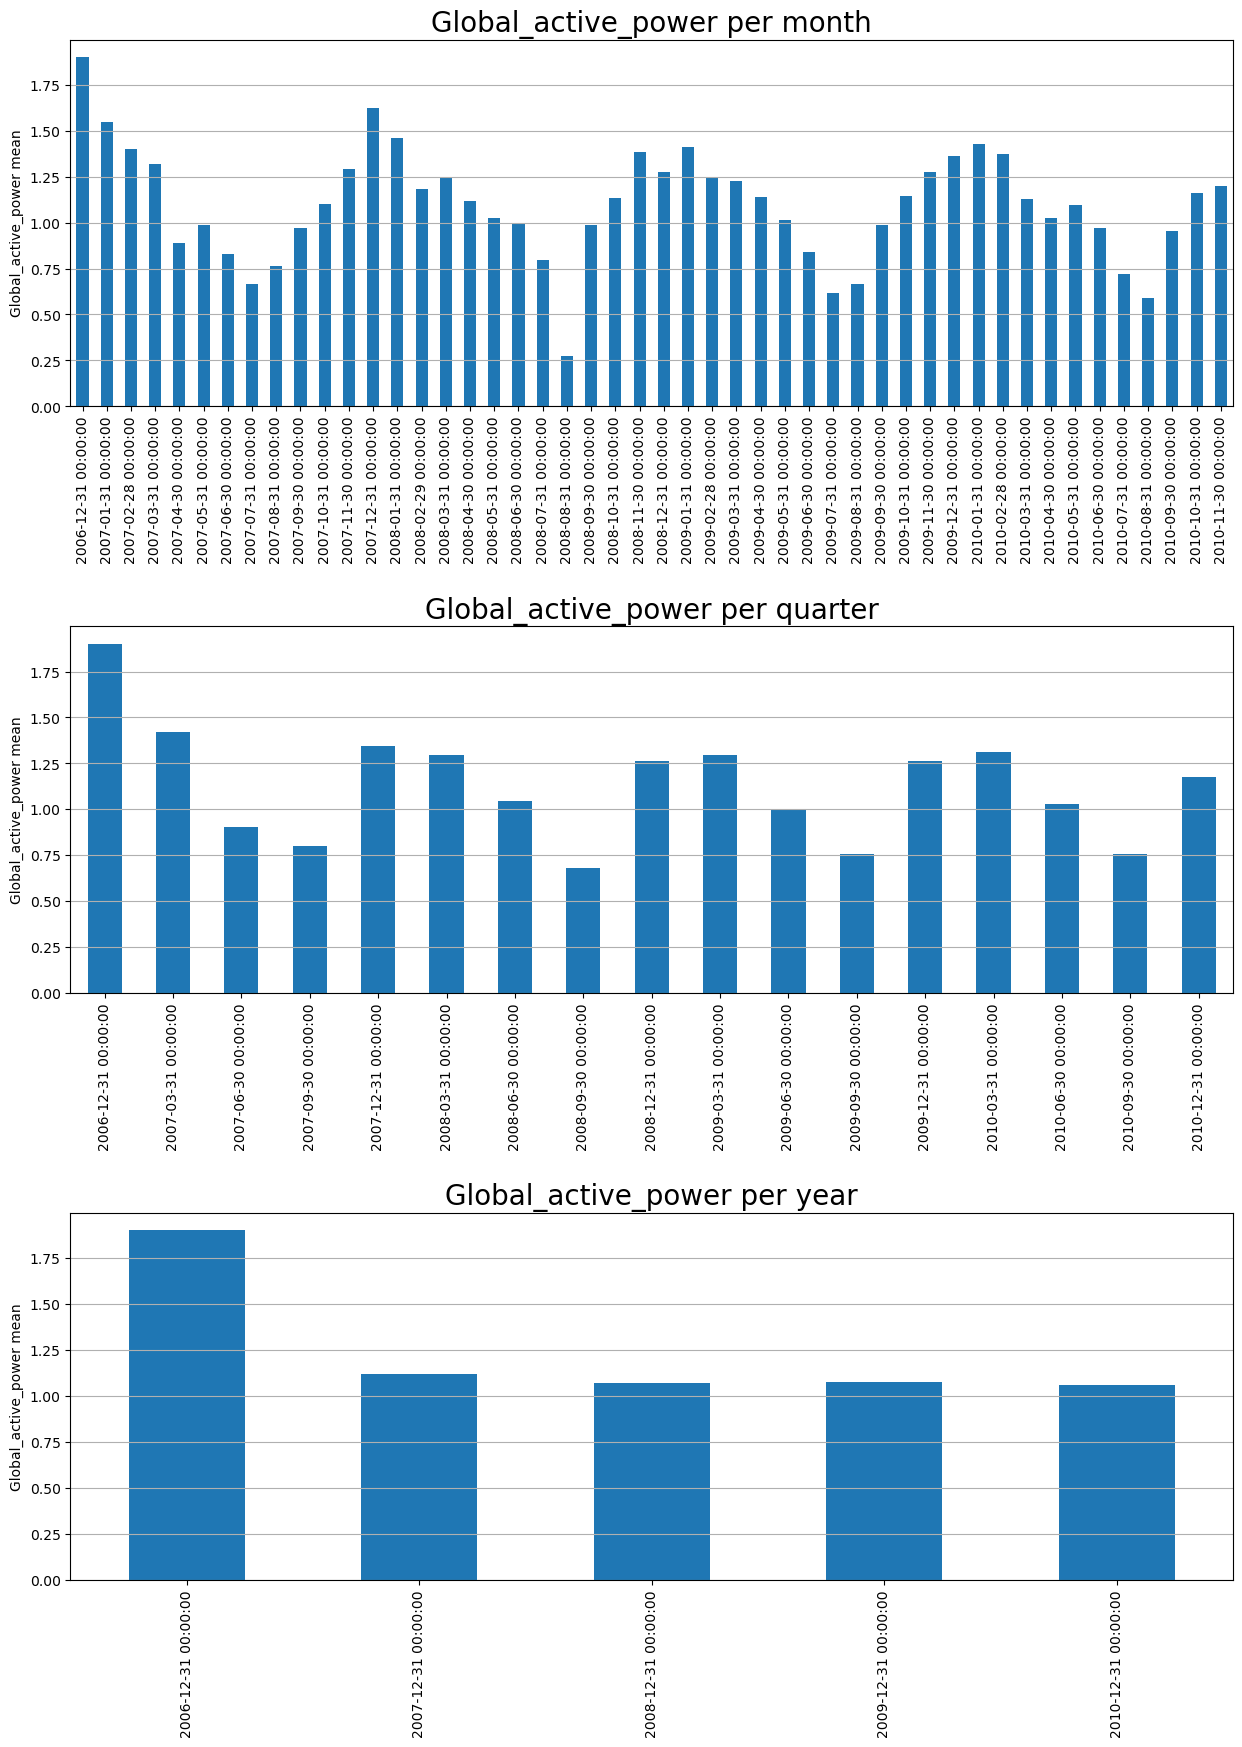

-----------------------------


C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])


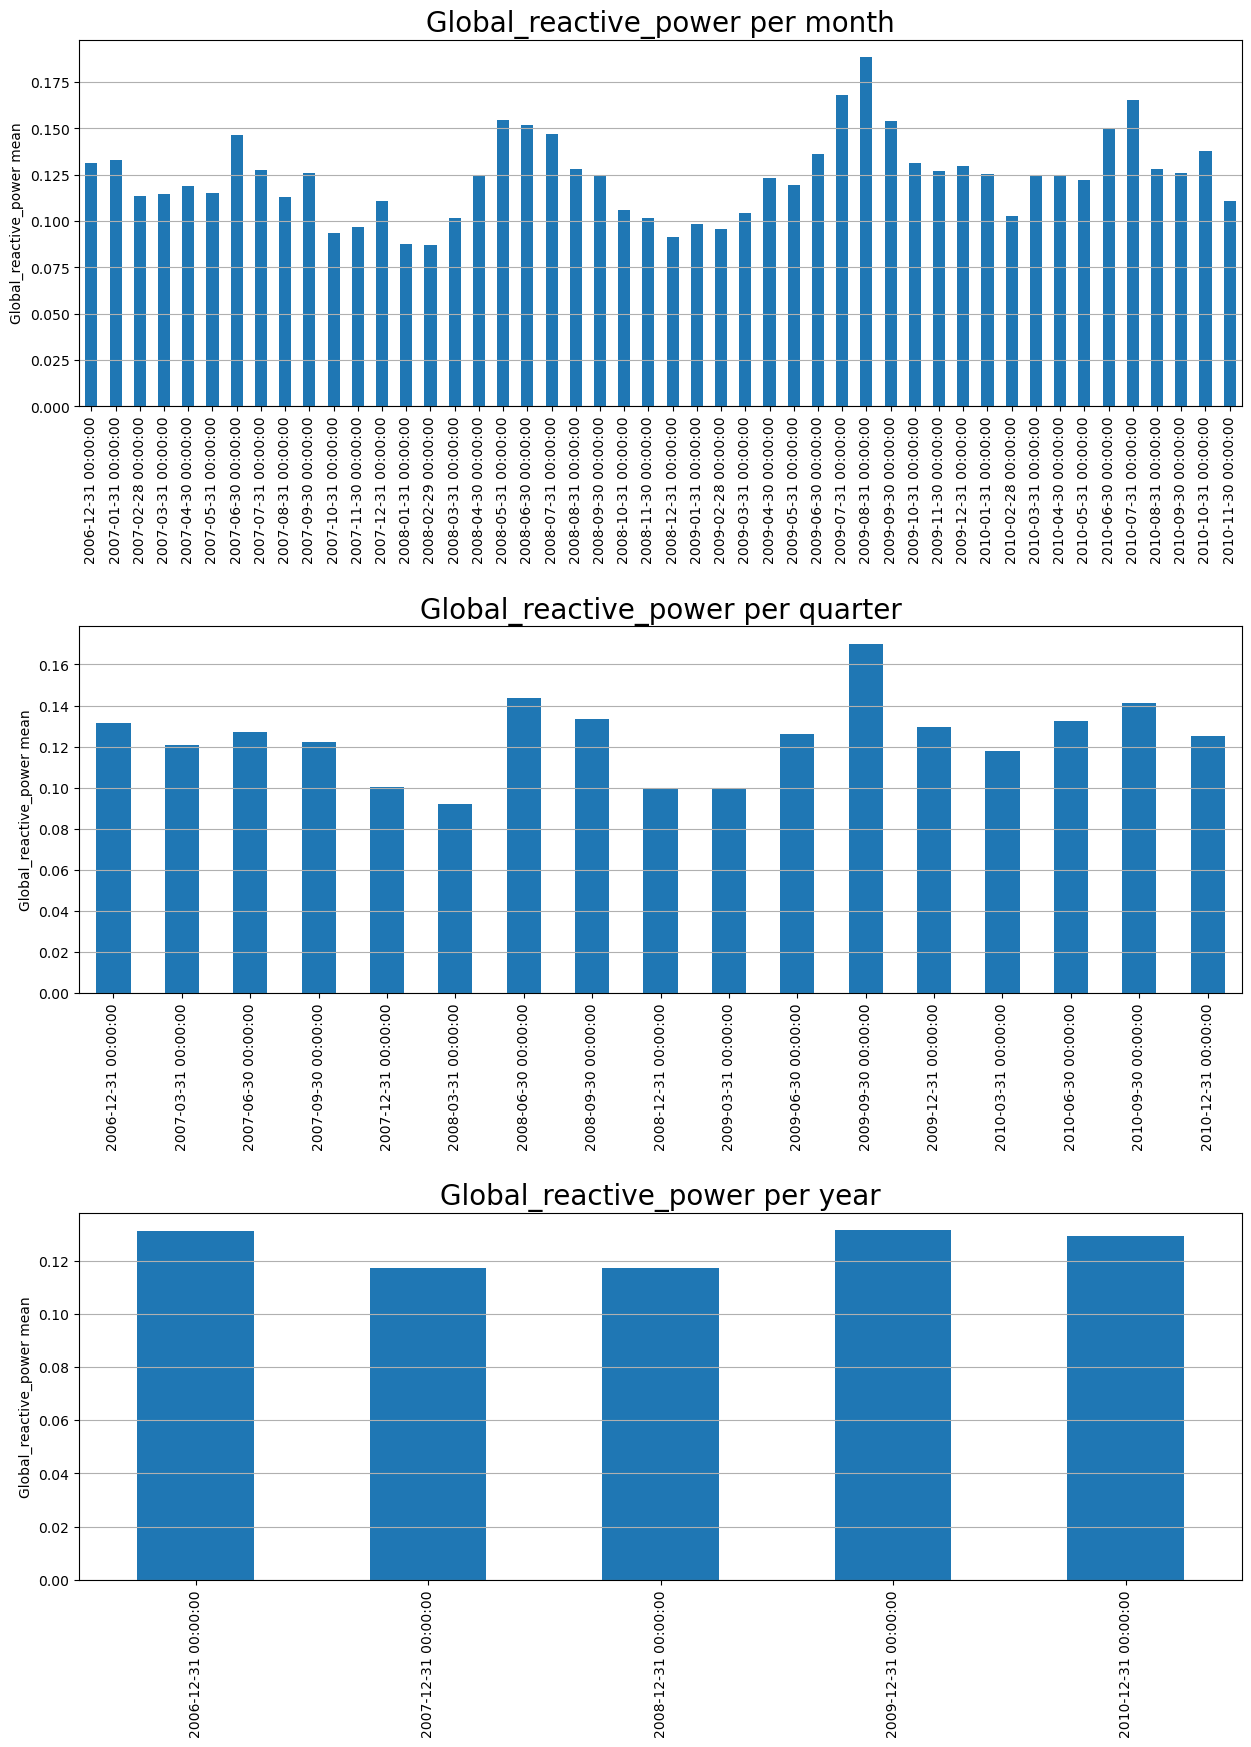

-----------------------------


C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])


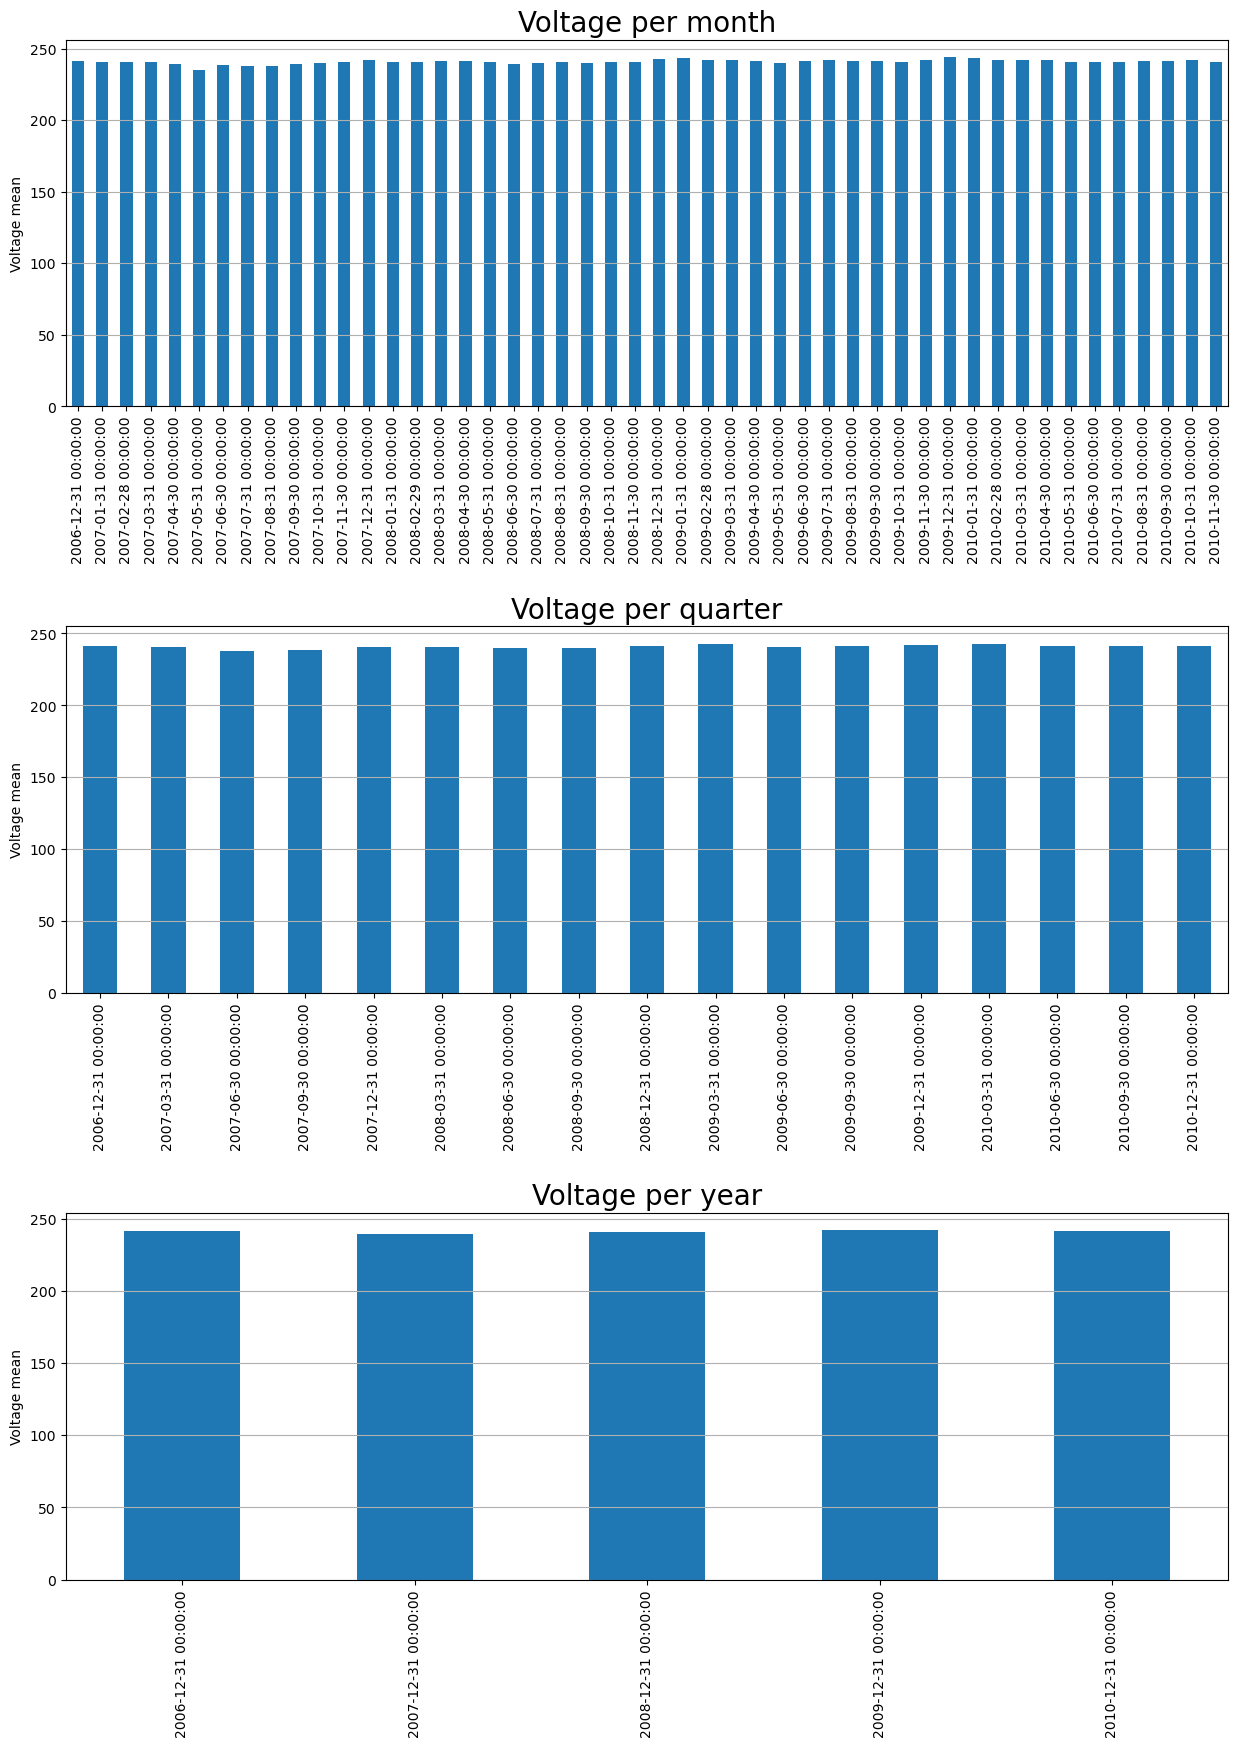

-----------------------------


C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])


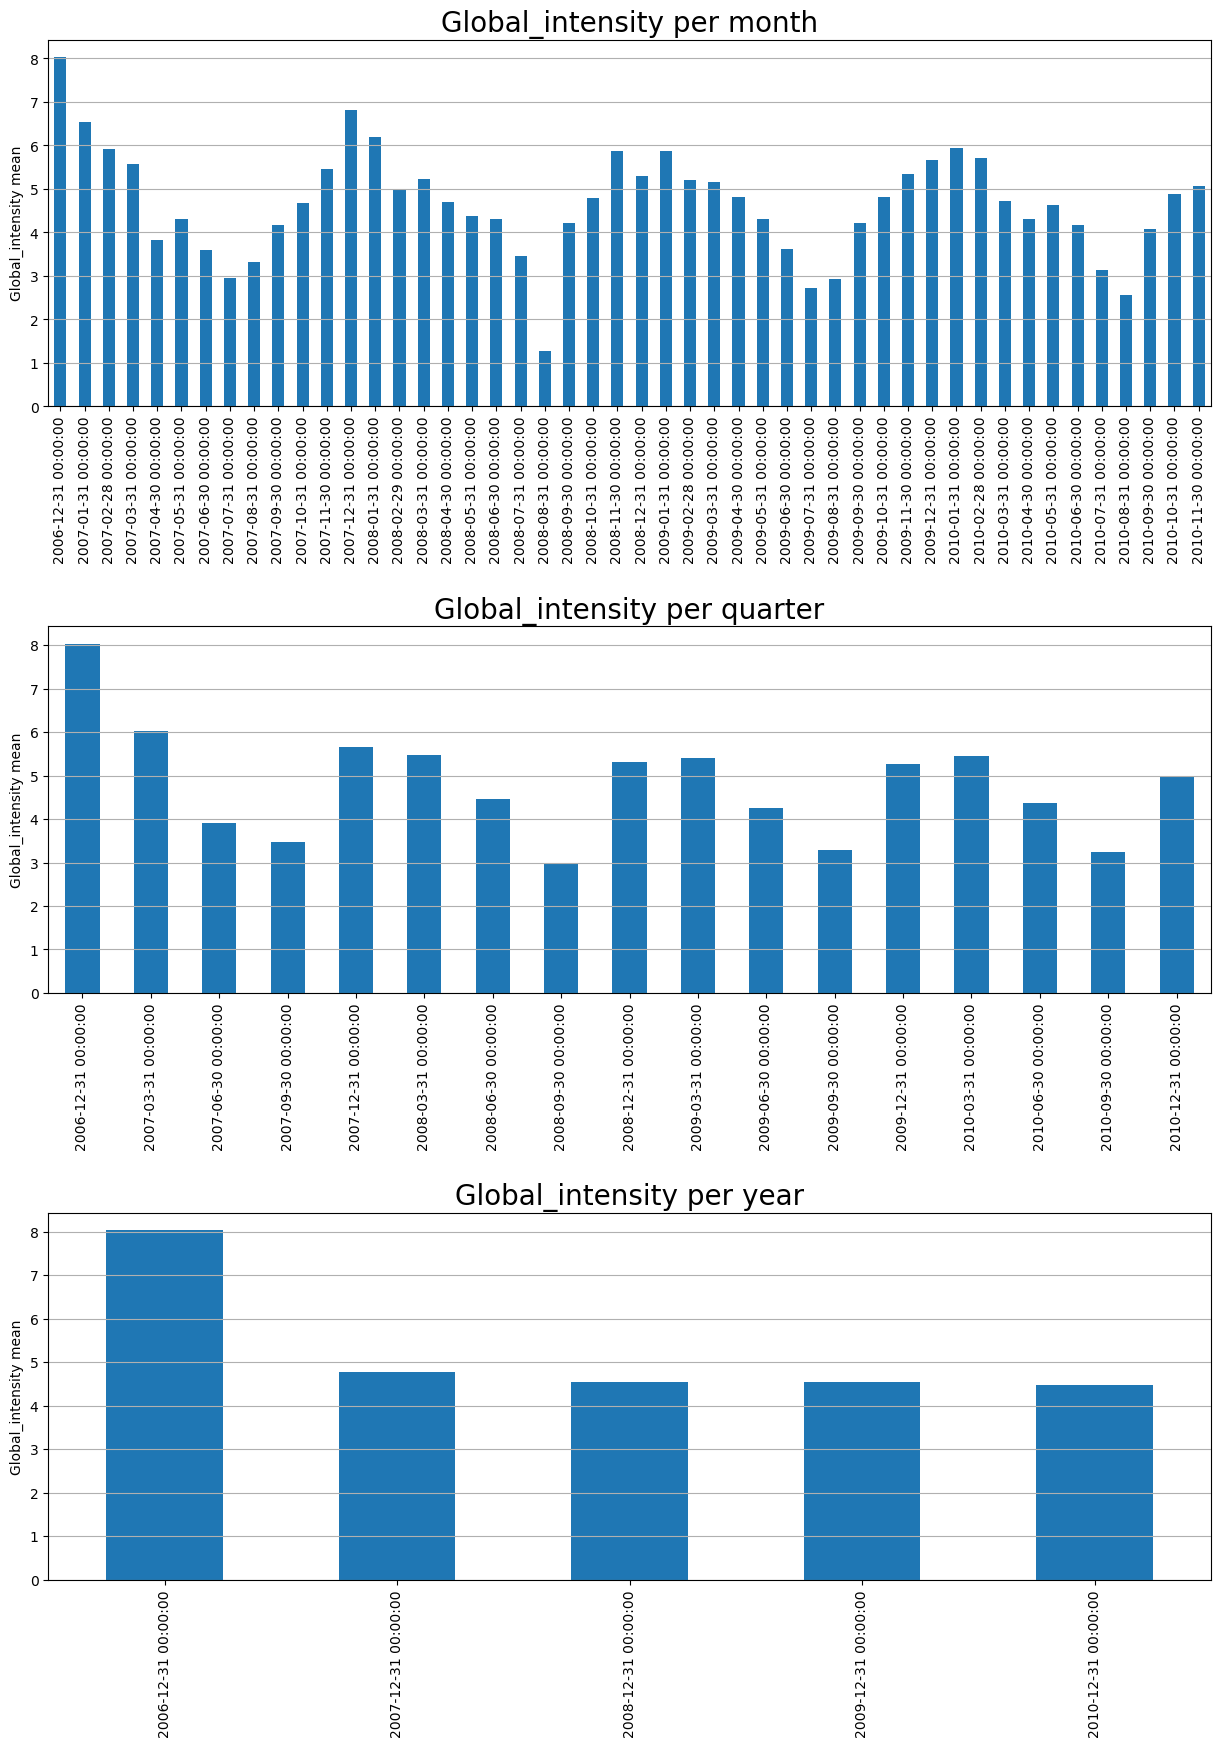

-----------------------------


C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])


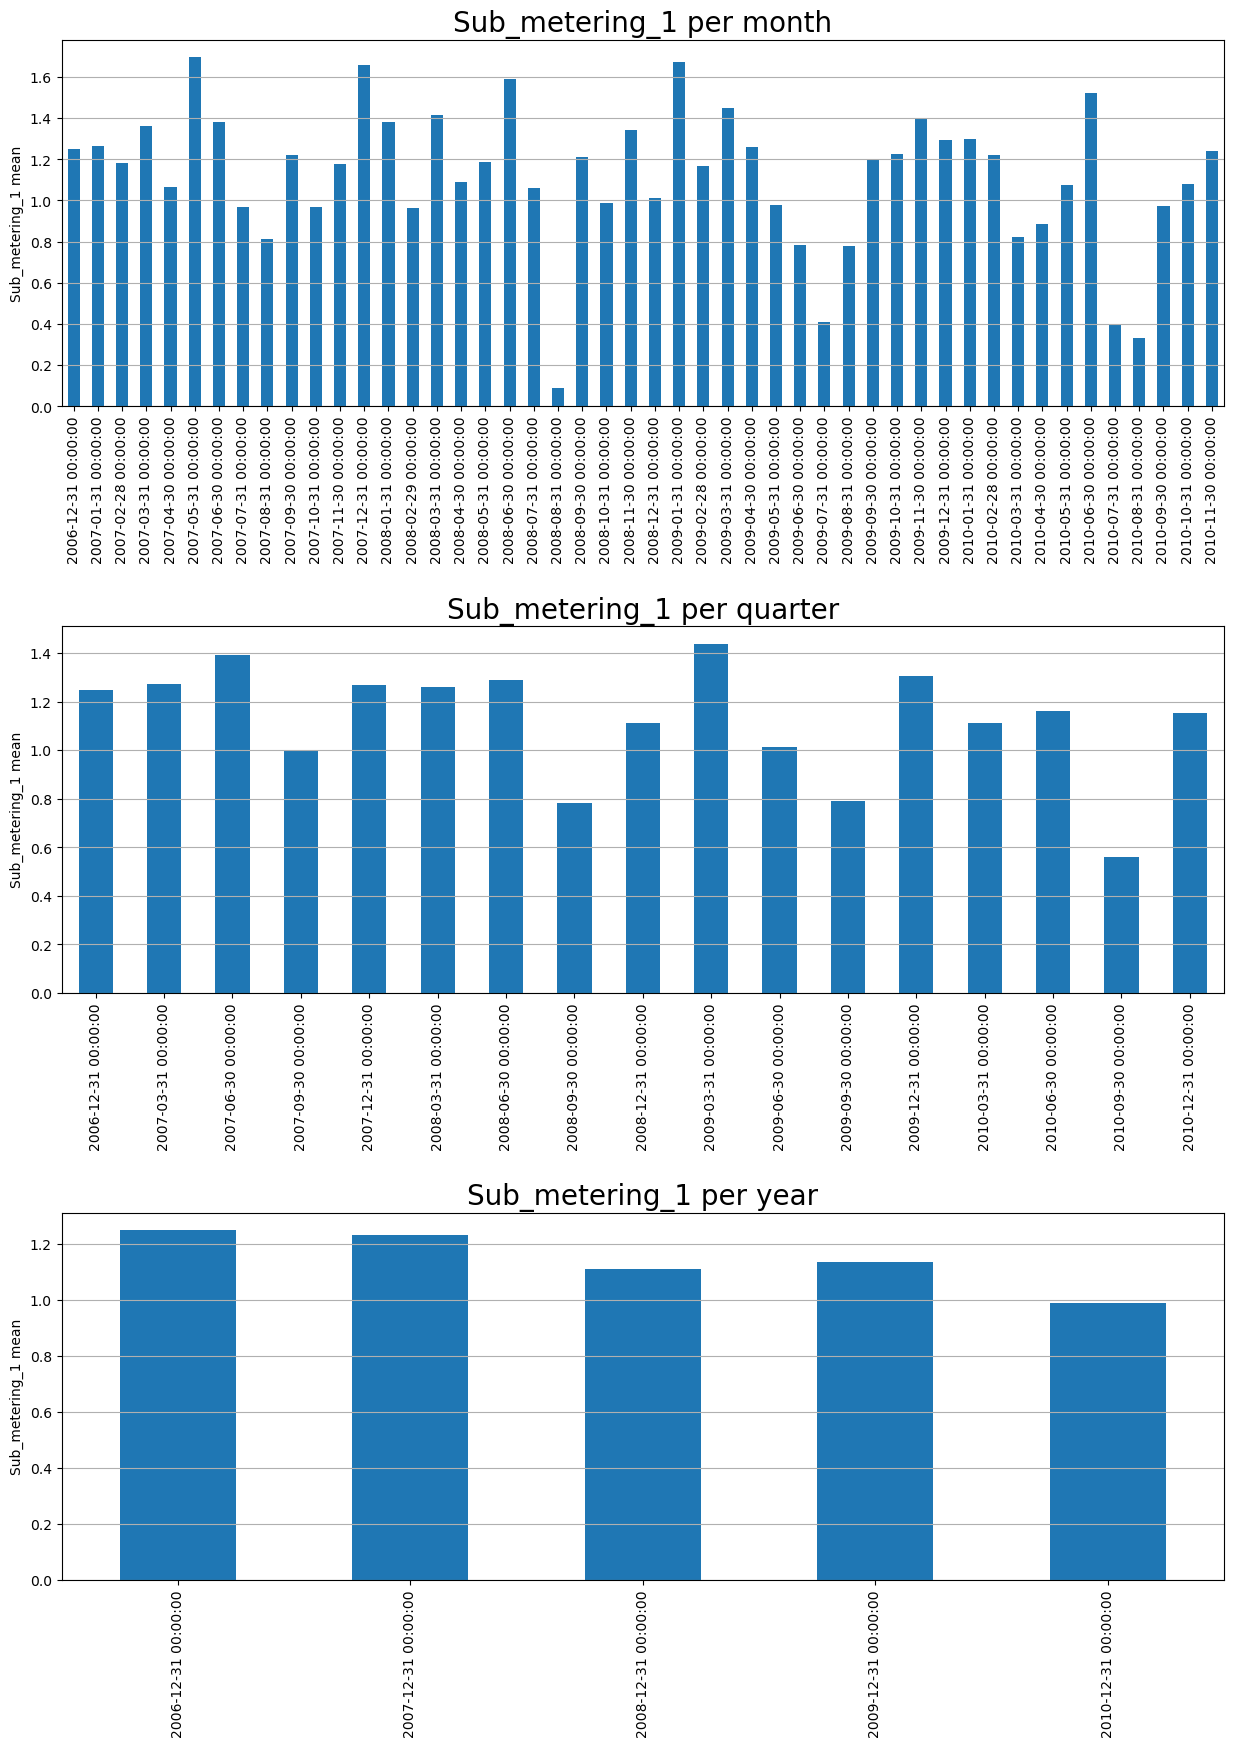

-----------------------------


C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])


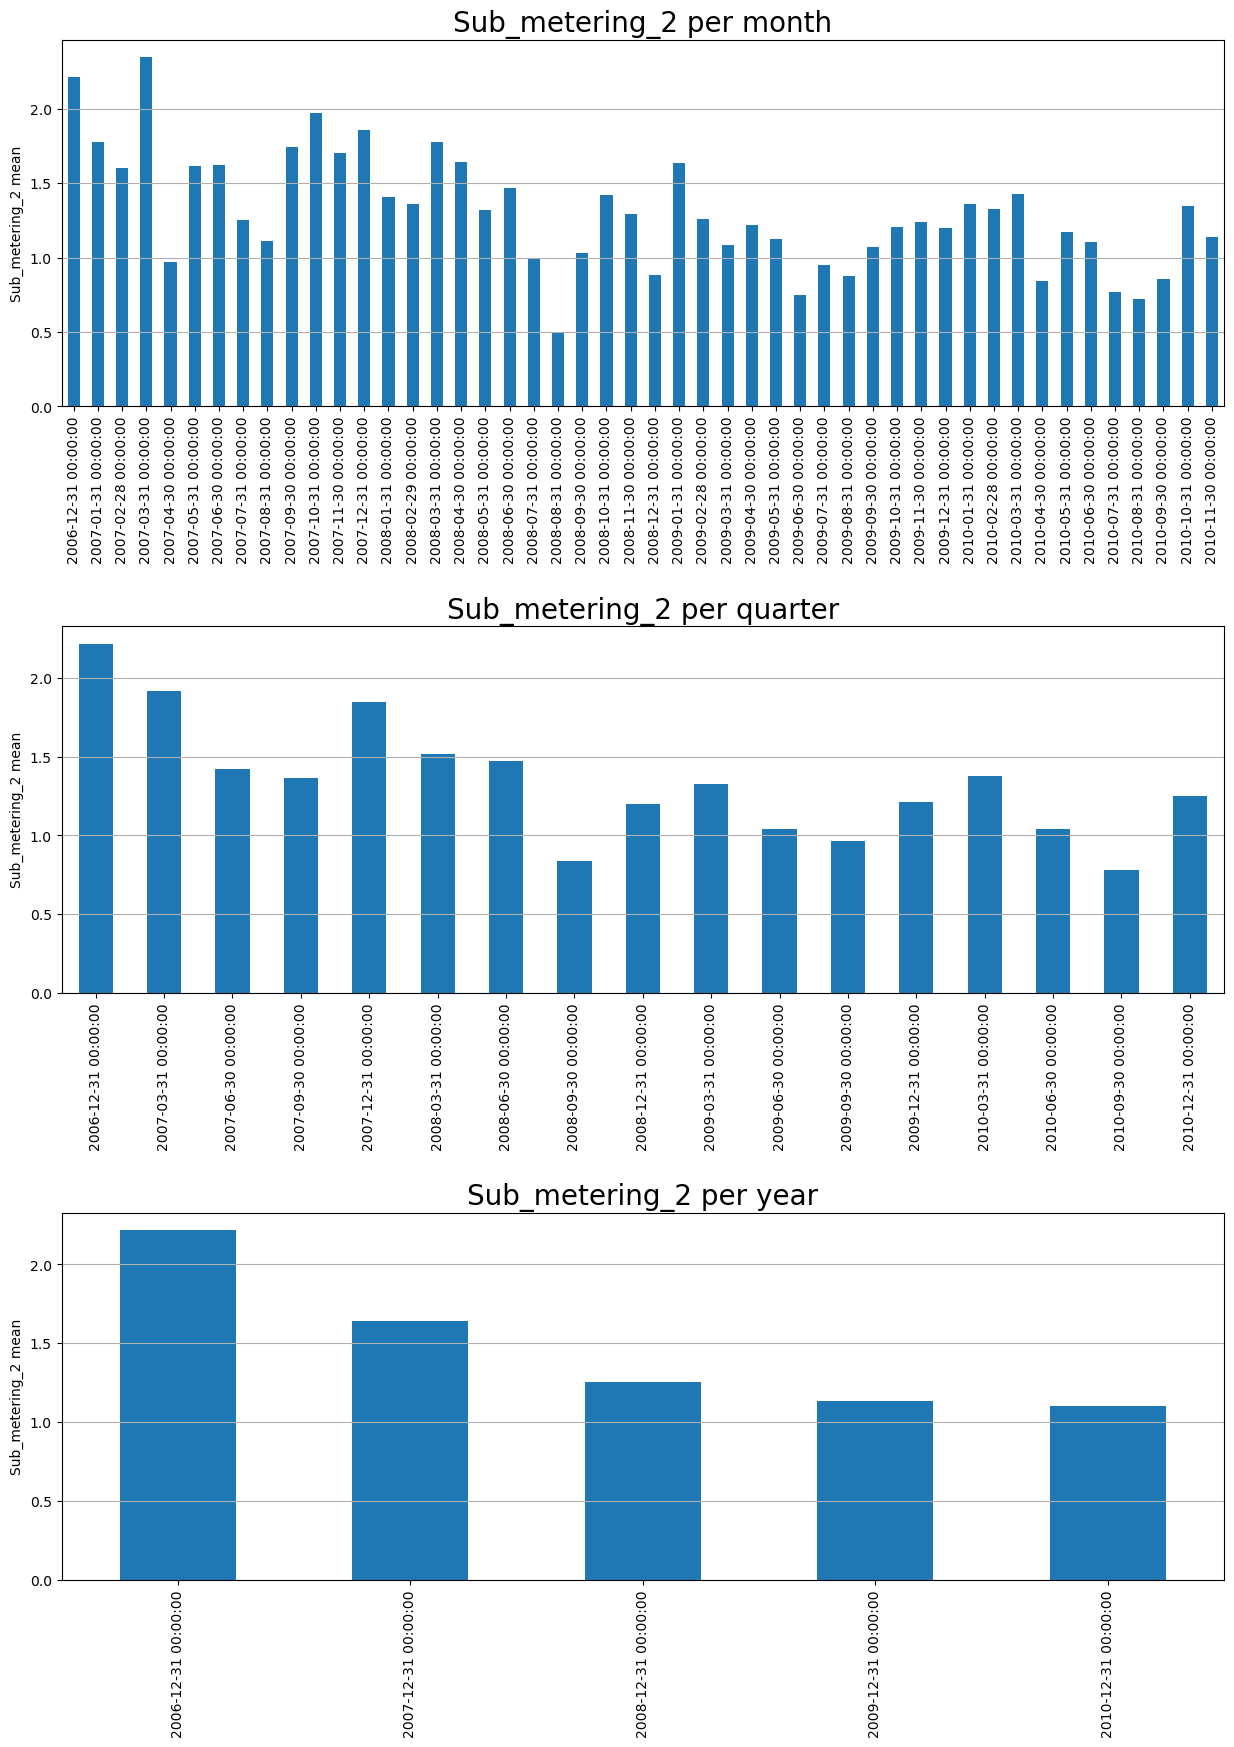

-----------------------------


C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
C:\Users\Vishal\AppData\Local\Temp\ipykernel_193304\382422853.py:20: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])


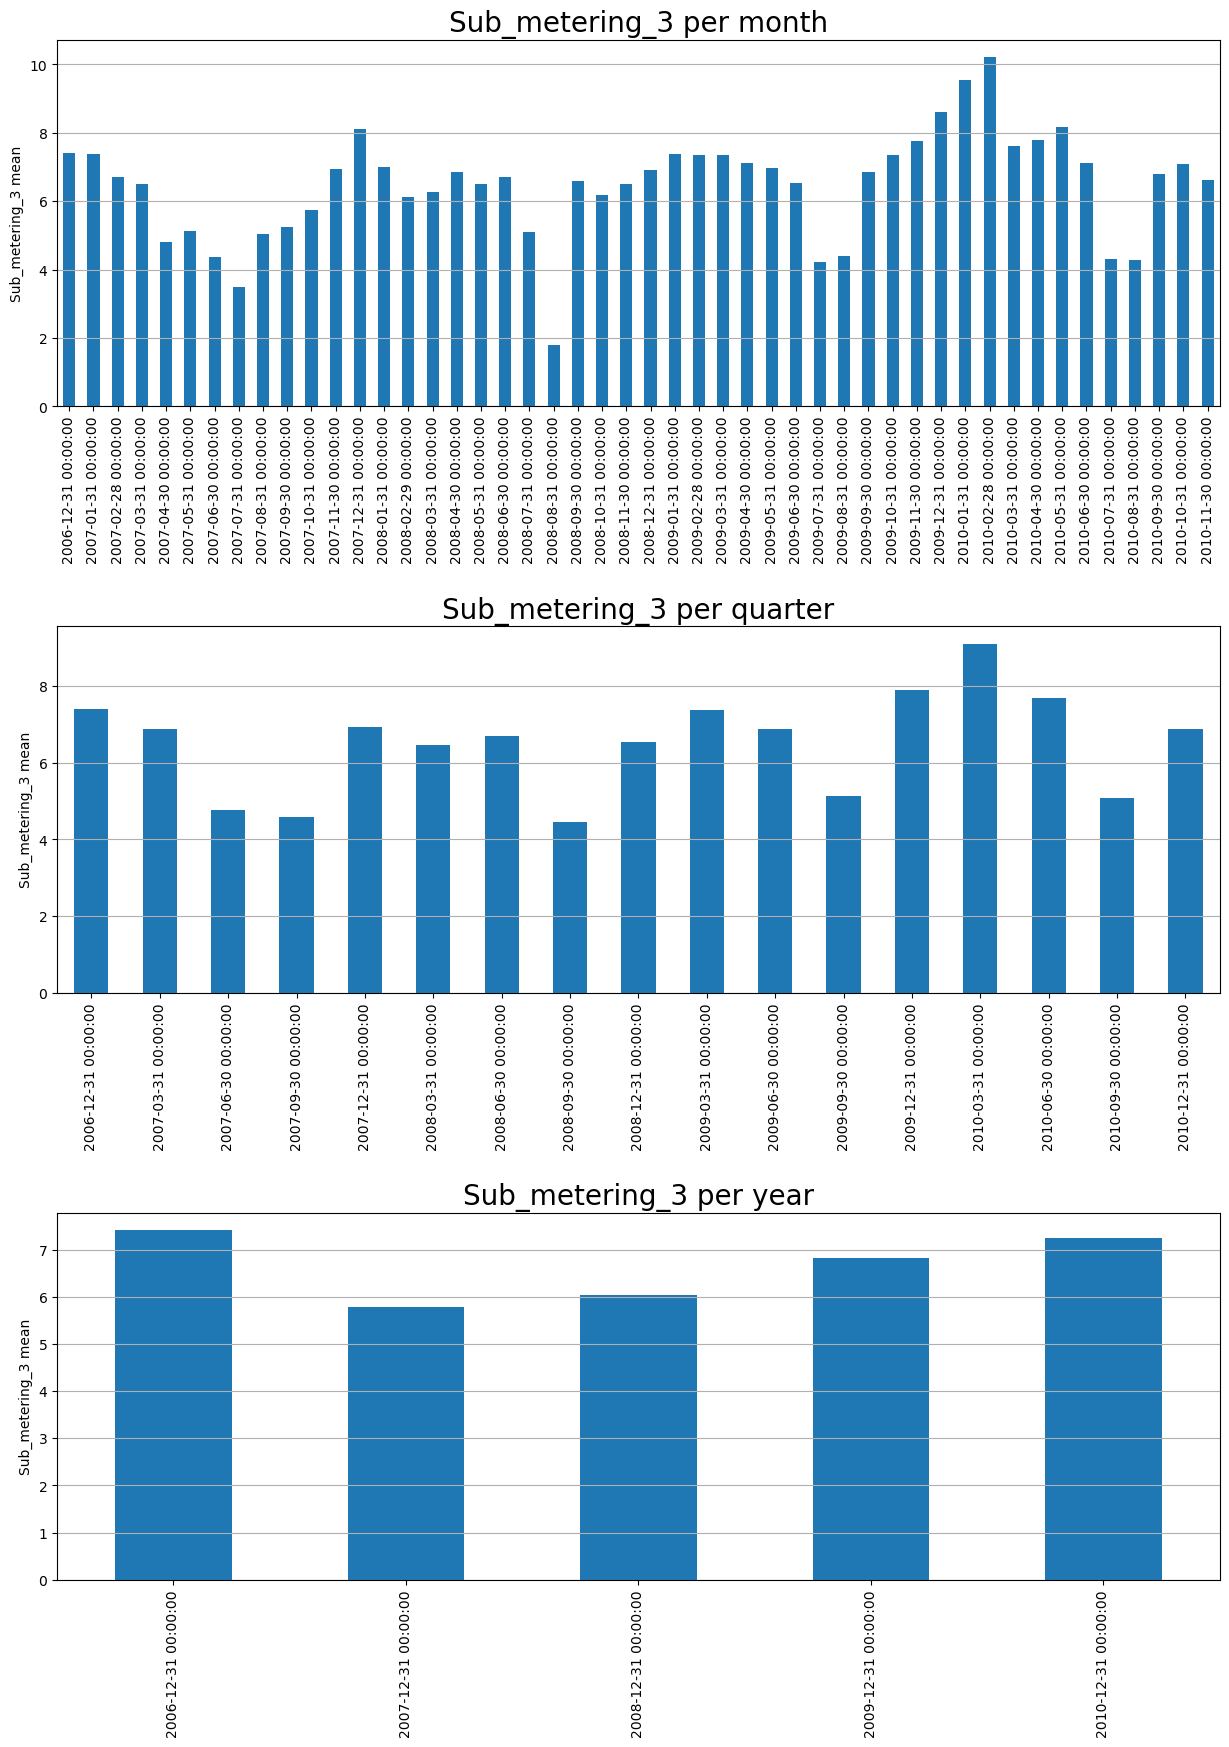

-----------------------------


In [16]:
for i in data.columns:
    feature_analyser(i,data)

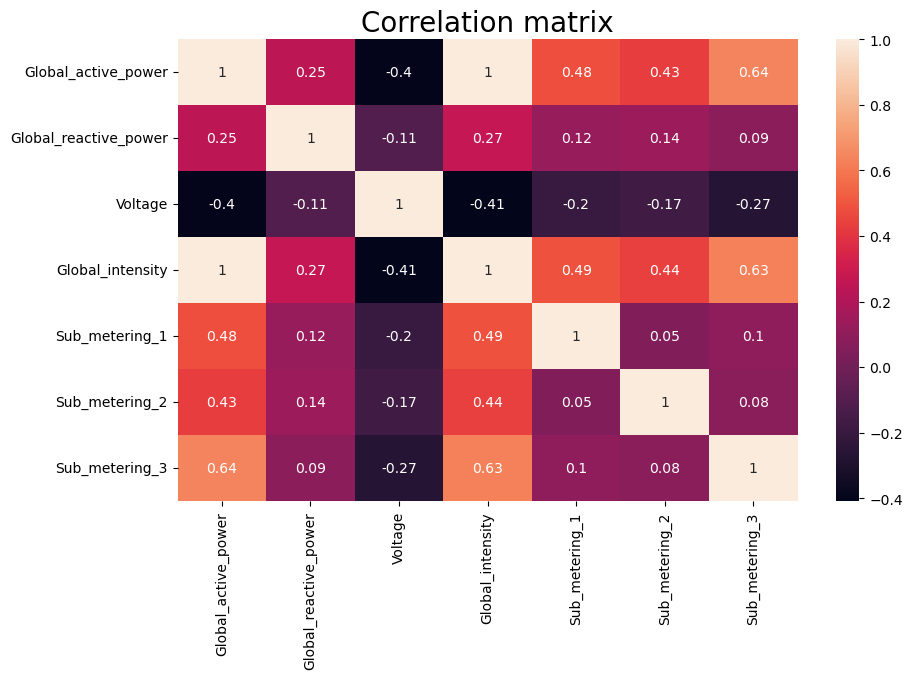

In [17]:
'''
    A correlation matrix is a table showing correlation 
    coefficients between a set of variables. Each cell in 
    the table shows the correlation between two variables. 
    Correlation matrices are used to summarize data, as an 
    input into a more advanced analysis, and as a 
    diagnostic for advanced analyses.
'''

# Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(data.corr().round(2),annot=True)
plt.title('Correlation matrix',fontsize = 20)
plt.show()

In [18]:
data.drop(columns=['Global_intensity'],inplace=True)

In [19]:
# Resample the data to obtain hourly means
df_reshaped = data.resample('D').mean()

# Feature engine
'''
    Based on the analysis of the data distribution, 
    it is evident that the variables exhibit distinct 
    seasonality. Therefore, we have generated two new
    variables, namely the day of the week and the season.
'''
df_reshaped['weekday'] = [get_weekday(day) for day in df_reshaped.index]
df_reshaped['season'] = [get_season(day) for day in df_reshaped.index]

df_reshaped['daily_avg'] = data.resample('D').mean()['Global_active_power'].values
df_reshaped['rolling_7d_avg'] = df_reshaped['Global_active_power'].rolling(window=7).mean()
df_reshaped['rolling_30d_avg'] = df_reshaped['Global_active_power'].rolling(window=30).mean()

# Define peak hours: between 6 PM and 10 PM
peak_hours = data.between_time('18:00', '22:00').resample('D').mean()['Global_active_power']
df_reshaped['peak_hour_avg'] = peak_hours.values

# OneHotEncoding
oh = OneHotEncoder(drop_last=True,variables=['weekday','season'])
df_reshaped = oh.fit_transform(df_reshaped)


Linear Regression Results:
Best Params: {}
RMSE: 0.20 KW per day
MAE: 0.14 KW per day
R²: 0.620


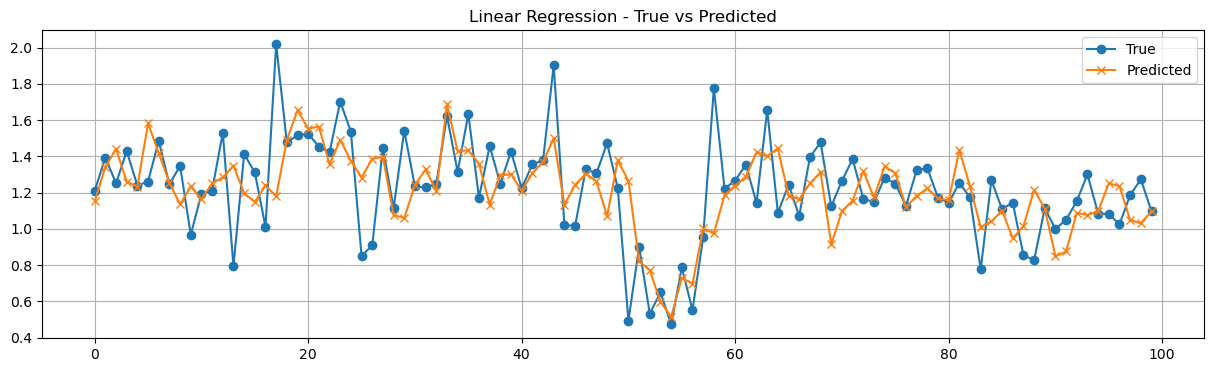


Random Forest Results:
Best Params: {'max_depth': None, 'n_estimators': 150}
RMSE: 0.19 KW per day
MAE: 0.14 KW per day
R²: 0.651


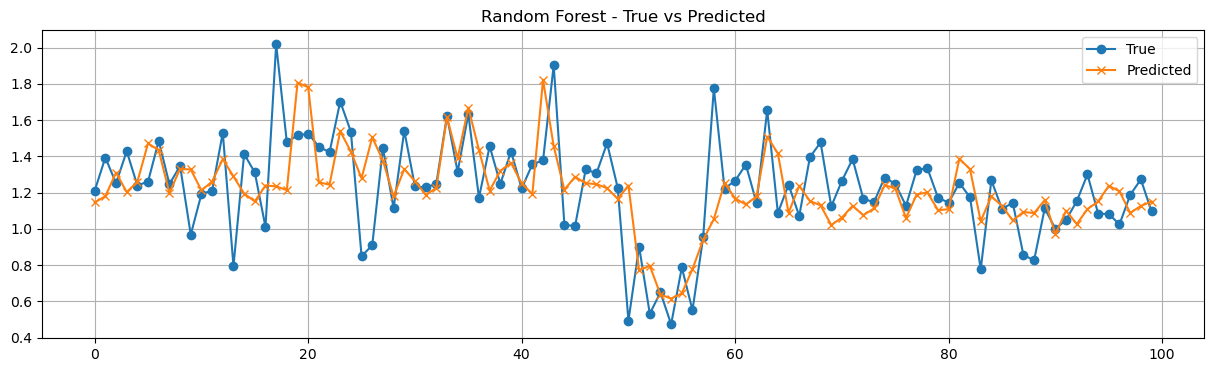


Gradient Boosting Results:
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
RMSE: 0.20 KW per day
MAE: 0.14 KW per day
R²: 0.639


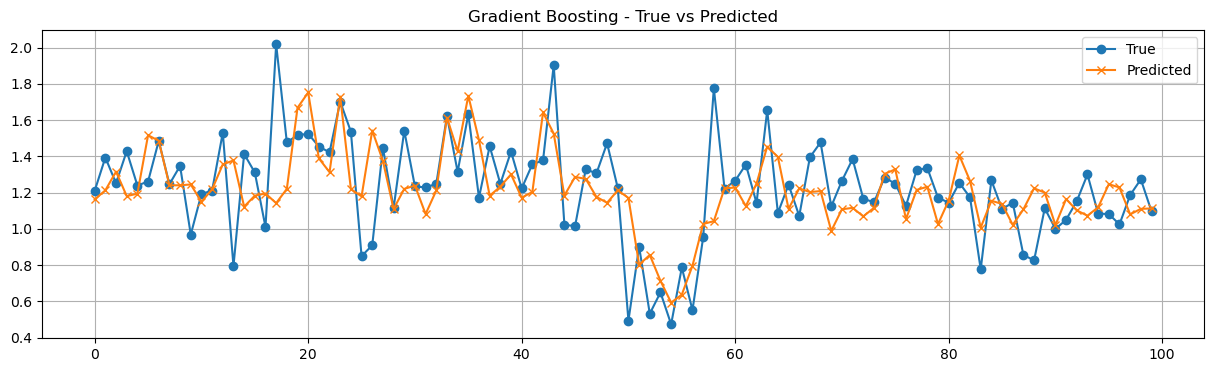


Neural Network Results:
Best Params: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'max_iter': 300}
RMSE: 0.23 KW per day
MAE: 0.16 KW per day
R²: 0.515


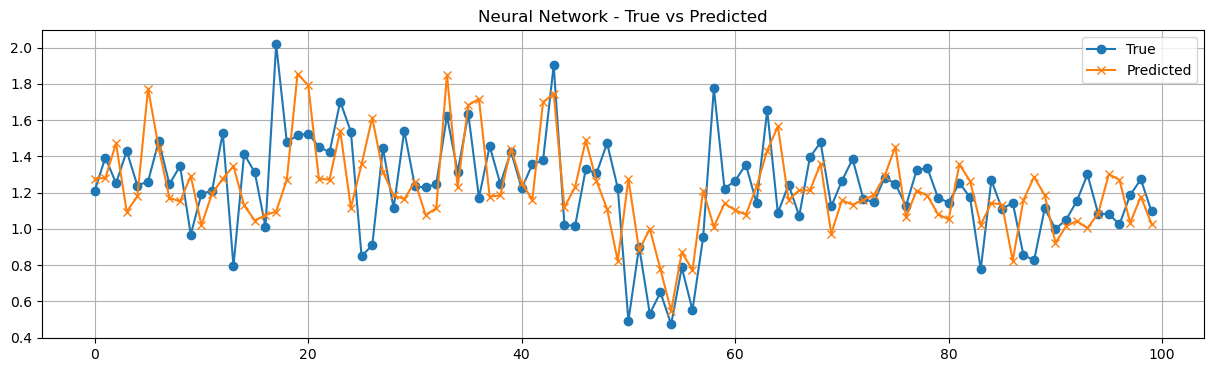

In [21]:
# Create a dataframe suitable for traditional models
LSTM_df = LSTM_df_generator(df_reshaped,rows_before=2)

# Split the data
X_train,X_test,y_train,y_test = train_test_split(
    LSTM_df.drop(LSTM_df.columns[[-1]],axis=1),
    LSTM_df[LSTM_df.columns[-1]].values,
    test_size=0.2,
    shuffle=False
)

# Scale features
sc_x = MinMaxScaler()
sc_y = MinMaxScaler()
X_train,X_test = sc_x.fit_transform(X_train),sc_x.transform(X_test)
y_train,y_test = sc_y.fit_transform(pd.DataFrame(y_train)),sc_y.transform(pd.DataFrame(y_test))

# Flatten for ML models
X_train_flat = X_train
X_test_flat = X_test

# Define hyperparameter grid for ML models
ml_param_grids = {
    'Linear Regression': {},
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (100,50)],
        'alpha': [0.0001, 0.001],
        'max_iter': [300, 500]
    }
}

ml_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Neural Network': MLPRegressor(random_state=42)
}

for name, model in ml_models.items():
    param_grid = ml_param_grids.get(name, {})
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train_flat, y_train.ravel())

    best_model = grid_search.best_estimator_
    preds = best_model.predict(X_test_flat)

    preds_inv = sc_y.inverse_transform(preds.reshape(-1, 1))
    y_test_inv = sc_y.inverse_transform(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    mae = mean_absolute_error(y_test_inv, preds_inv)
    r2 = r2_score(y_test_inv, preds_inv)

    print(f"\n{name} Results:")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"RMSE: {rmse:.2f} KW per day")
    print(f"MAE: {mae:.2f} KW per day")
    print(f"R²: {r2:.3f}")

    plt.figure(figsize=(15, 4))
    plt.plot(y_test_inv[:100], label='True', marker='o')
    plt.plot(preds_inv[:100], label='Predicted', marker='x')
    plt.title(f'{name} - True vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()
